In [1]:
import torch
from torch import Tensor
import numpy as np

import matplotlib.pyplot as plt

$$
(n+1) P_{n+1}(x) = (2n + 1) x P_n (x) - n P_{n-1}(x)
$$

donde
$$
P_0(x) = 1, P_1(x) = x
$$

aqui una implementación para crear el grafo de autoderivación implementando lo que sabemos de los polinomios de legendre

In [4]:
import torch
from torch.autograd import Function, Variable

# Funciones auxiliares para los polinomios de Legendre
# genera polinomios de legendre usando recurrencia
def Pl(n, x):
    if n == 0:
        return 0*x + 1 # esto hace que devuelva un tensor
    elif n == 1:
        return x
    elif n == 2:
        return 0.5*(3*x**2 - 1)
    elif n == 3:
        return 0.5*(5*x**3 - 3*x)
    elif n == 4:
        return (1/8)*(35*x**4 - 30*x**2 + 3)
    elif n == 5:
        return (1/8)*(63*x**5 - 70*x**3 + 15*x)
    elif n == 6:
        return (1/16)*(231*x**6 - 315*x**4 + 105*x**2 - 5)
    elif n == 7:
        return (1/16)*(429*x**7 - 693*x**5 + 315*x**3 - 35*x)

    else:
        n = n - 1 # ya la formula esta en P(n+1,x)
        p1 = (2*n + 1) * x * Pl(n, x)
        p2 = n * Pl(n-1,x)
        return (p1 - p2 )/(n+1)

def dxPl(n, x):
    if n == 0:
        return 0 * x + 0
    elif n == 1:
        return 0 * x + 1
    else:
        n = n - 1
        return (n + 1) * Pl(n, x) + x * dxPl(n, x)

class PLegendre(Function):

    @staticmethod
    def forward(ctx, n, input):
        ctx.save_for_backward(input)
        ctx.n = n
        output = Pl(n, input)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        n = ctx.n
        grad_output_var = torch.autograd.Variable(grad_output, requires_grad=False)
        input_var = torch.autograd.Variable(input, requires_grad=True)
        dxpl = dxPl(n, input_var)
        return None, grad_output_var * dxpl


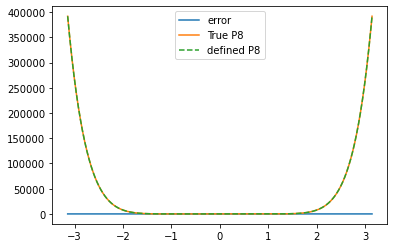

error total: 0.0007988085853867233


In [ ]:
# testing
def P8(x):
    return (1/128)*(6435*x**8-12012*x**6+6930*x**4-1260*x**2+35)

y_8 = P8(x)
y_Pl8 = Pl(8,x)
error = y_8 - y_Pl8
plt.plot(x, error, label = "error")
plt.plot(x, y_8, label = "True P8")
plt.plot(x, y_Pl8,'--', label = "defined P8")
plt.legend()
plt.show()

print(f"error total: {sum(error)/len(error)}")


In [ ]:
n = torch.tensor([2], dtype=torch.float64, requires_grad=True)
x = torch.tensor([-1,0,1], dtype=torch.float64, requires_grad=True)

output = PLegendre.apply(n, x)
output.backward(torch.ones_like(output))

grad_n = n.grad
grad_x = x.grad


print("grad_n:", grad_n)
print("grad_x:", grad_x)


grad_n: None
grad_x: tensor([-3.,  0.,  3.], dtype=torch.float64)


como se observa, la manera correcta de utilizar es
```python
P2 = PLegendre.apply
P2(n,x)
```

Pues entonces guarda el grafo computacional correcto

In [5]:
dtype = torch.float

In [3]:
import math

dtype = torch.float
device = torch.device("cpu")

x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)

a = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
b = torch.full((), -1.0, device=device, dtype=dtype, requires_grad=True)
c = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
d = torch.full((), 0.3, device=device, dtype=dtype, requires_grad=True)

In [ ]:
# que polinomio de legendre usar
n = 3

learning_rate = 5e-6
for t in range(2000):
    # To apply our Function, we use Function.apply method. We alias this as 'P3'.
    P3 = PLegendre

    # Forward pass: compute predicted y using operations; we compute
    # P3 using our custom autograd operation.
    y_pred = a + b * P3.apply(n,c + d * x)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(t, loss.item())

    # Use autograd to compute the backward pass.
    loss.backward()

    # Update weights using gradient descent
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        # Manually zero the gradients after updating weights
        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None

print(f'Result: y = {a.item()} + {b.item()} * P3({c.item()} + {d.item()} x)')

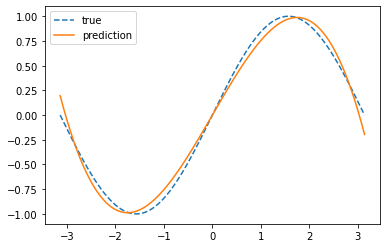

In [ ]:
# la aproximación de la sinusoidal será
y;
y_bestPred = (a + b * P3.apply(n,c + d * x)).detach().numpy()

plt.plot(x, y, '--',label='true')
plt.plot(x, y_bestPred, label='prediction')
plt.legend()
plt.show()

In [22]:
class LegendrePolynomial(torch.nn.Module):
    """ Generate a sum of legendre polynomials that work with torch grad"""
    def __init__(self, coef, domain=None):
        super(LegendrePolynomial, self).__init__()
        self.coef = torch.nn.Parameter(coef, requires_grad=True)
        self.domain = domain

    def __call__(self, x):
        result = 0
        for idx,C in enumerate(self.coef):
            result += C * PLegendre.apply(idx, x)
        return result



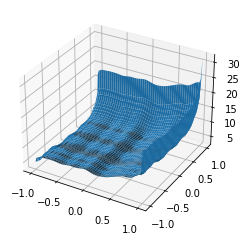

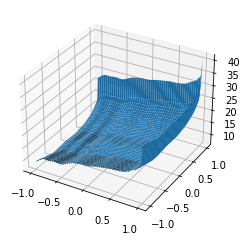

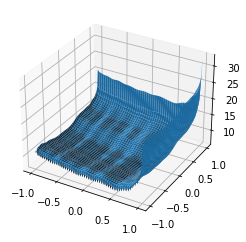

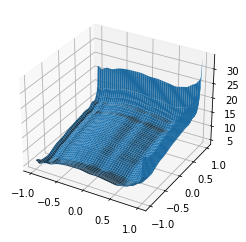

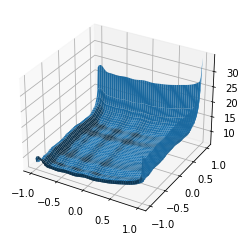

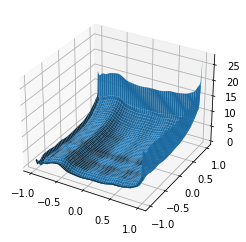

KeyboardInterrupt: 

In [ ]:
xL,xR = -1,1
yL, yR = -1,1


import matplotlib.pyplot as plt
xs = torch.linspace(xL, xR, steps=100)
ys = torch.linspace(yL, yR, steps=100)
x, y = torch.meshgrid(xs, ys, indexing='xy')

for i in range(3):
    coefx = torch.tensor([np.random.randint(10)/i for i in range(1,25)],dtype=torch.float64, requires_grad=True)
    coefy = torch.tensor([np.random.randint(10)/i for i in range(1,25)],dtype=torch.float64,requires_grad=True)
    fx = LegendrePolynomial(coefx)
    fy = LegendrePolynomial(coefy, domain=[yL,yR])
    z = fx(x) + fy(y)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x.detach(), y.detach(), z.detach())
    plt.show()

## Testing
Que tan bien se pueden adaptar a distintos tipos de potenciales

### $V(x) = x^2$


### $V(x) = H(|x|-0.5)$
Un potencial que tenga steps

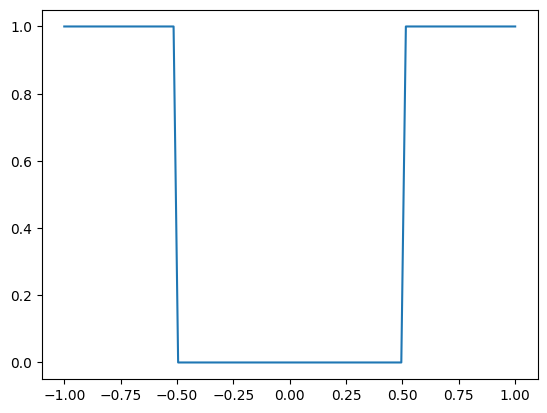

In [5]:
X = torch.linspace(-1, 1, steps=100)
y = torch.tensor([0.0 if np.abs(x) < 0.5 else 1.0 for x in X], dtype=torch.float32)
plt.plot(X, y)

In [ ]:
coefx = torch.tensor([np.random.randint(10)/i for i in range(1,25)],dtype=torch.float32)

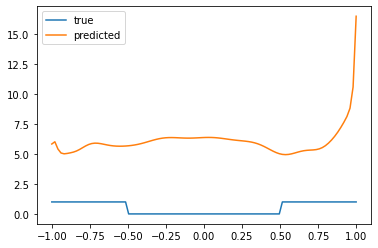

In [ ]:
fx = LegendrePolynomial(coefx)
y_pred = fx(X)

plt.plot(X, y, label='true')
plt.plot(X, y_pred.detach(), label='predicted')
plt.legend()
plt.show()

In [ ]:
print(y_pred.dtype)
print(y.dtype)
print(coefx.dtype)


torch.float32
torch.float32
torch.float32


In [17]:
import torch
import numpy as np
from torch.optim import SGD
loss_arr = []

In [ ]:
%%time
loss_fn = torch.nn.MSELoss()
optimizer = SGD(fx.parameters(), lr=0.01)


num_epochs = 1000
for epoch in range(num_epochs):
    y_pred = fx(X)
    loss = loss_fn(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_arr.append(loss.item())
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/1000, Loss: 32.871376037597656
Epoch 2/1000, Loss: 31.62372398376465
Epoch 3/1000, Loss: 30.42516326904297
Epoch 4/1000, Loss: 29.273759841918945
Epoch 5/1000, Loss: 28.167638778686523
Epoch 6/1000, Loss: 27.10500717163086
Epoch 7/1000, Loss: 26.084138870239258
Epoch 8/1000, Loss: 25.103391647338867
Epoch 9/1000, Loss: 24.161157608032227
Epoch 10/1000, Loss: 23.25592613220215
Epoch 11/1000, Loss: 22.38623046875
Epoch 12/1000, Loss: 21.550657272338867
Epoch 13/1000, Loss: 20.747861862182617
Epoch 14/1000, Loss: 19.976543426513672
Epoch 15/1000, Loss: 19.235462188720703
Epoch 16/1000, Loss: 18.523408889770508
Epoch 17/1000, Loss: 17.83924102783203
Epoch 18/1000, Loss: 17.18185806274414
Epoch 19/1000, Loss: 16.550193786621094
Epoch 20/1000, Loss: 15.943236351013184
Epoch 21/1000, Loss: 15.360003471374512
Epoch 22/1000, Loss: 14.799560546875
Epoch 23/1000, Loss: 14.261005401611328
Epoch 24/1000, Loss: 13.7434720993042
Epoch 25/1000, Loss: 13.2

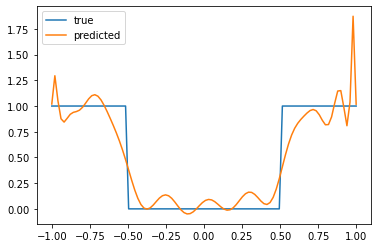

CPU times: total: 1.36 s
Wall time: 1.48 s


In [ ]:
%%time
y_pred = fx(X)

plt.plot(X, y, label='true')
plt.plot(X, y_pred.detach(), label='predicted')
plt.legend()
plt.show()

In [ ]:
fx.coef

Parameter containing:
tensor([ 0.4988,  0.0065,  0.9379,  0.0819, -0.2681,  0.1350, -0.0307,  0.0126,
         0.5253, -0.0068,  0.0424,  0.0407, -0.1502,  0.0823,  0.2164,  0.0833,
        -0.0552, -0.0152, -0.2584, -0.1691, -0.0890, -0.0539, -0.3502, -0.1981],
       requires_grad=True)

In [ ]:
coefx

tensor([ 0.4988,  0.0065,  0.9379,  0.0819, -0.2681,  0.1350, -0.0307,  0.0126,
         0.5253, -0.0068,  0.0424,  0.0407, -0.1502,  0.0823,  0.2164,  0.0833,
        -0.0552, -0.0152, -0.2584, -0.1691, -0.0890, -0.0539, -0.3502, -0.1981])

In [ ]:
torch.save(fx, f'legendre_1000ep_b10.pt')

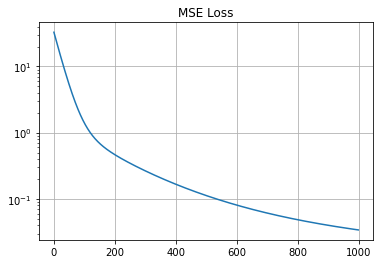

In [ ]:
np.savetxt('loss2.txt', loss_arr)
plt.plot(loss_arr)
plt.yscale('log')
plt.grid()
plt.title("MSE Loss")
plt.show()

#### 100 parameters
Adding more polynomials
and the relation with more computation time

In [15]:
import torch
import numpy as np
from torch.optim import SGD
loss_arr = []

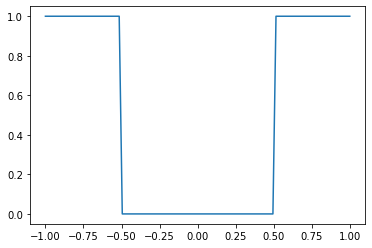

In [72]:
X = torch.linspace(-1, 1, steps=100)
y = torch.tensor([0.0 if np.abs(x) < 0.5 else 1.0 for x in X], dtype=torch.float32)
plt.plot(X, y)

In [14]:
%%time
# N > 40 tiempos sobre 1 hora
N = 30
coefx = torch.tensor([np.random.randint(10)/i for i in range(1,N)],
    dtype=torch.float32)
fx = LegendrePolynomial(coefx)
y_pred = fx(X)

CPU times: user 7.1 s, sys: 17 ms, total: 7.12 s
Wall time: 7.14 s


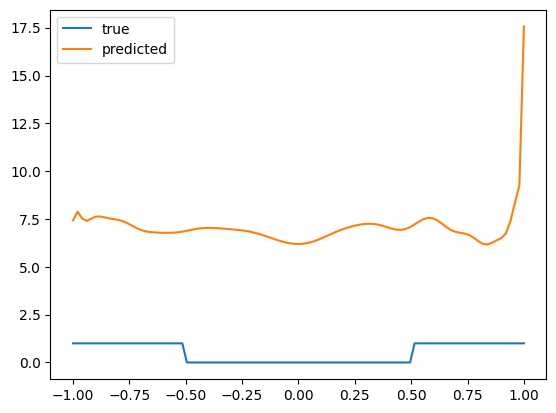

In [15]:
plt.plot(X, y, label='true')
plt.plot(X, y_pred.detach(), label='predicted')
plt.legend()
plt.show()

In [19]:
%%time
loss_fn = torch.nn.MSELoss()
optimizer = SGD(fx.parameters(), lr=0.01)


num_epochs = 1000
for epoch in range(num_epochs):
    y_pred = fx(X)
    loss = loss_fn(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_arr.append(loss.item())
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/1000, Loss: 44.508602142333984
Epoch 2/1000, Loss: 42.77066421508789
Epoch 3/1000, Loss: 41.101585388183594
Epoch 4/1000, Loss: 39.49863815307617
Epoch 5/1000, Loss: 37.959190368652344
Epoch 6/1000, Loss: 36.480709075927734
Epoch 7/1000, Loss: 35.060787200927734
Epoch 8/1000, Loss: 33.69709396362305
Epoch 9/1000, Loss: 32.38739013671875
Epoch 10/1000, Loss: 31.129531860351562
Epoch 11/1000, Loss: 29.921464920043945
Epoch 12/1000, Loss: 28.761205673217773
Epoch 13/1000, Loss: 27.646865844726562
Epoch 14/1000, Loss: 26.57660484313965
Epoch 15/1000, Loss: 25.548681259155273
Epoch 16/1000, Loss: 24.561416625976562
Epoch 17/1000, Loss: 23.613191604614258
Epoch 18/1000, Loss: 22.702451705932617
Epoch 19/1000, Loss: 21.827714920043945
Epoch 20/1000, Loss: 20.987548828125
Epoch 21/1000, Loss: 20.180578231811523
Epoch 22/1000, Loss: 19.40549087524414
Epoch 23/1000, Loss: 18.661012649536133
Epoch 24/1000, Loss: 17.945938110351562
Epoch 25/1000, Loss: 17.259092330932617
Epoch 26/1000, Los

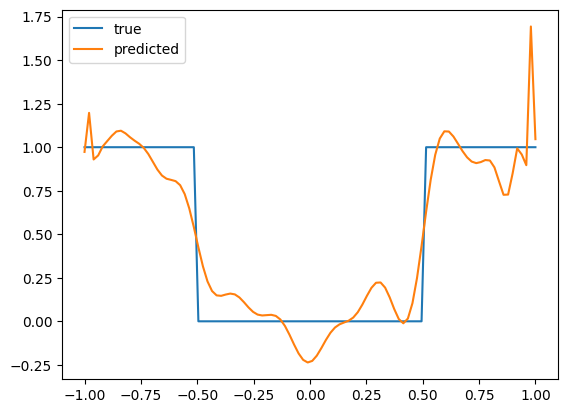

In [20]:
y_pred = fx(X)

plt.plot(X, y, label='true')
plt.plot(X, y_pred.detach(), label='predicted')
plt.legend()
plt.show()

In [21]:
torch.save(fx, f'legendre_1000ep_b10.pt')

Adding more Polynomials dosen't add more efficieny, so it could be useful to add parameter's for other kinds of functions and create a highly parametrizable potential

In [111]:
class ParametricPotential(torch.nn.Module):
    """ Generate a sum of legendre polynomials that work with torch grad"""
    def __init__(self, Lcoef, Hcoef, Hinput):
        super(ParametricPotential, self).__init__()
        self.Lcoef = torch.nn.Parameter(Lcoef, requires_grad=True)
        assert len(Hcoef) == len(Hinput)
        self.Hcoef = torch.nn.Parameter(Hcoef, requires_grad=True)
        self.Hinput = torch.nn.Parameter(Hinput, requires_grad=True)
        self.midVal = torch.tensor([1], dtype=dtype)


    def __call__(self, x):
        legendre_result = 0.0
        heaviside_result = 0.0
        for idx,C in enumerate(self.Lcoef):
            relu = torch.nn.ReLU()

            legendre_result += C * PLegendre.apply(idx, x)
            #legendre_result += C * relu(x-self.Hinput[idx]) * PLegendre.apply(idx, x)  
    

        for i in range(len(self.Hcoef)):
            relu = torch.nn.ReLU()
            # heaviside_result += self.Hcoef[i]* relu(x-self.Hinput[i],torch.tensor([1], dtype=dtype))
            #heaviside_result += self.Hcoef[i]* relu(x-self.Hinput[i])
            heaviside_result += self.Hcoef[i] * 1/(X+self.Hinput[i] + 1e-10)
        
        

        return legendre_result + heaviside_result



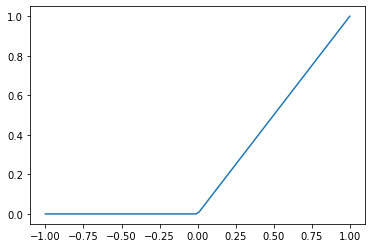

In [28]:
relu = torch.nn.ReLU()
plt.plot(X,relu(X))

In [112]:
NLegendre = 10
NHeaviside = 10

Lcoef = torch.tensor([10/i for i in range(1,NLegendre+1)], dtype=dtype)
Hcoef = torch.tensor([i-3 for i in range(NHeaviside)], dtype=dtype)
Hins = torch.tensor([(i-3)/NHeaviside for i in range(NHeaviside)], dtype=dtype)
pV = ParametricPotential(Lcoef, Hcoef, Hins)

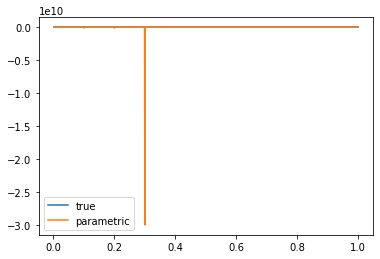

In [113]:
y_pred = pV(X)

plt.plot(X, y, label='true')
plt.plot(X, y_pred.detach(), label='parametric')
plt.legend()
plt.show()

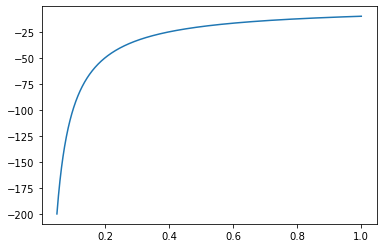

In [118]:
X = torch.linspace(0.05,1, 1000, dtype=dtype)
y = -10/X
plt.plot(X, y)

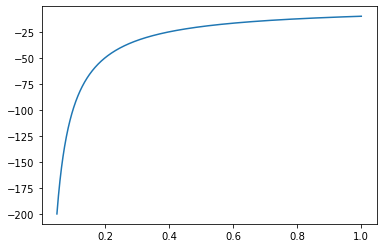

In [123]:
plt.plot(X, y)

In [124]:
y_pred = pV(X)
loss = loss_fn(y_pred, y)
loss.item()

58128084.0

In [137]:
%%time
loss_fn = torch.nn.MSELoss()
optimizer = SGD(pV.parameters(), lr=0.01)


num_epochs = 3000
for epoch in range(num_epochs):
    y_pred = pV(X)
    loss = loss_fn(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_arr.append(loss.item())
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/3000, Loss: 12667.314453125
Epoch 2/3000, Loss: 12667.1806640625
Epoch 3/3000, Loss: 12667.046875
Epoch 4/3000, Loss: 12666.912109375
Epoch 5/3000, Loss: 12666.7763671875
Epoch 6/3000, Loss: 12666.6416015625
Epoch 7/3000, Loss: 12666.509765625
Epoch 8/3000, Loss: 12666.376953125
Epoch 9/3000, Loss: 12666.2421875
Epoch 10/3000, Loss: 12666.107421875
Epoch 11/3000, Loss: 12665.974609375
Epoch 12/3000, Loss: 12665.8369140625
Epoch 13/3000, Loss: 12665.7041015625
Epoch 14/3000, Loss: 12665.5732421875
Epoch 15/3000, Loss: 12665.4384765625
Epoch 16/3000, Loss: 12665.3037109375
Epoch 17/3000, Loss: 12665.169921875
Epoch 18/3000, Loss: 12665.0380859375
Epoch 19/3000, Loss: 12664.904296875
Epoch 20/3000, Loss: 12664.771484375
Epoch 21/3000, Loss: 12664.63671875
Epoch 22/3000, Loss: 12664.50390625
Epoch 23/3000, Loss: 12664.3701171875
Epoch 24/3000, Loss: 12664.236328125
Epoch 25/3000, Loss: 12664.1025390625
Epoch 26/3000, Loss: 12663.96875
Epoch 27/3000, Loss: 12663.8359375
Epoch 28/300

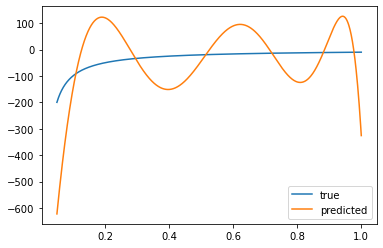

In [138]:
y_pred = pV(X)

plt.plot(X, y, label='true')
plt.plot(X, y_pred.detach(), label='predicted')
plt.legend()
plt.show()

In [132]:
plt.plot(loss_arr)a
#plt.yscale('log')
plt.title('Error evolution')
plt.xlabel('epoch')
plt.show()

SyntaxError: invalid syntax (878579402.py, line 1)